### This new notebook is designed for evaluating probabilistic time-series predictions

In [87]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

from IPython.display import clear_output
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from ipywidgets import interact
import numpy as np
import torch

import models.ICL
import importlib
importlib.reload(models.ICL)
from models.ICL import MultiResolutionPDF, recursive_refiner, trim_kv_cache
import copy

from scipy.stats import norm
from tqdm import tqdm
import pickle
import os
if not os.path.exists('MultiPDFList'):
    os.makedirs('MultiPDFList')

# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    ### dump pickled torch files here for later plotting
    os.makedirs('plot_output')
    
if not os.path.exists('gif_plots'):
    ### dump generated GIFs
    os.makedirs('gif_plots')


### Generate Dynamical Systems Data

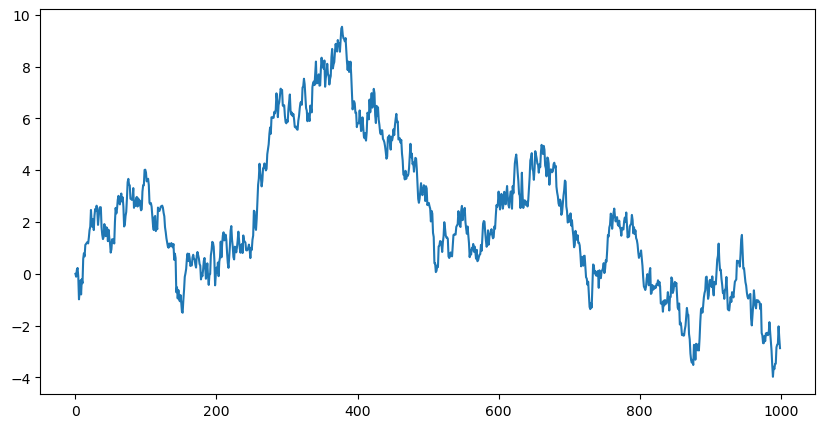

In [10]:
### Drift-Diffusion SDE
prec = 3

# Time discretization
Nt = 1000 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
np.random.seed(6)
# a = 0.3  
a = 0
# Noise level
sigma = 0.8

# Initialize the time series
x = 0  # Starting point
time_series = [x]
mean_series = [x]
sigma_series = [0]

# Generate the drift-diffusion time series
for t in range(1, Nt):
    x_mean = x + a*dt
    x_sigma = sigma * np.sqrt(dt)
    dW =  np.random.normal()  # Wiener process (Brownian motion)
    x = x_mean + x_sigma * dW
    
    time_series.append(x)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)
    
plt.figure(figsize=(10, 5))
plt.plot(time_series, alpha = 1)



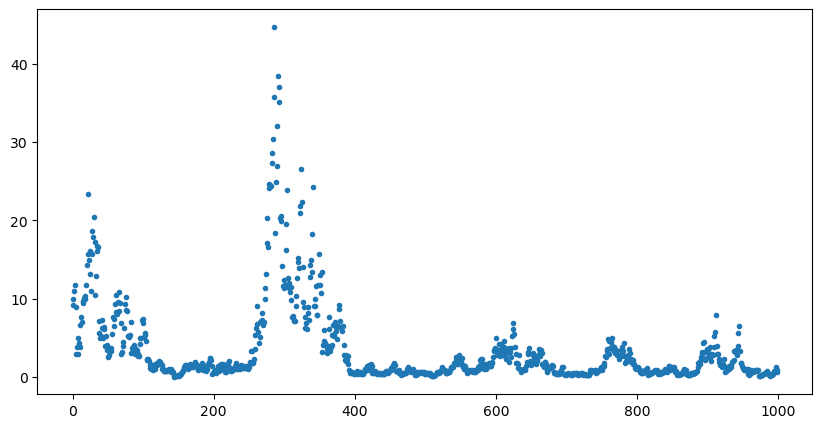

In [11]:
### Geometric Brownian Motion 
prec = 3

# Time discretization
Nt = 1000 # number of steps
# Nt = 800 # number of steps

dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
np.random.seed(6)
# a = 0.3  
sigma = 0.6
a = sigma**2/2
# Noise level


# Initialize the time series
x = 10  # Starting point
time_series = [x]
mean_series = [x]
sigma_series = [0]

# Generate the drift-diffusion time series
for t in range(1, Nt):
    x_mean = x + a*dt
    x_sigma = x * sigma * np.sqrt(dt)
    dW =  np.random.normal()  # Wiener process (Brownian motion)
    x = x_mean + x_sigma * dW
    
    time_series.append(x)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)
    


plt.figure(figsize=(10, 5))
plt.plot(time_series, alpha = 1, lw = 0, marker = 'o', markersize = 3)
# plt.yscale('log')
plt.show()


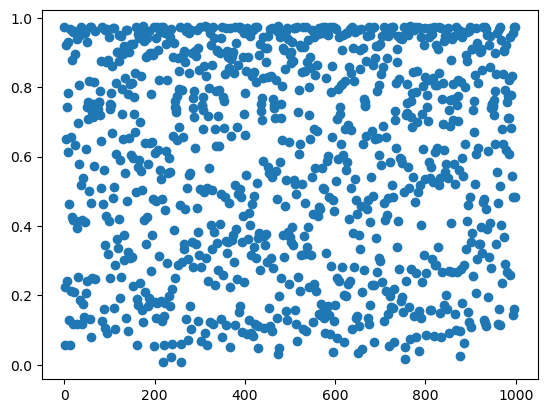

In [98]:
### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

# Parameters
prec = 2
x = 0.5  # Initial condition
Nt = 1000
# Number of iterations

r = 3.9  # Control parameter
np.random.seed(6)
sigma = 0.0136 # Noise level


time_series = []
time_series_diff = []
mean_series = []
sigma_series = []
### Initial uncertainty is zero
x_diff = 0
for i in range(Nt):
    x_mean = logistic_map(r, x)
    x_sigma = x_diff * sigma
    x = logistic_map(r, x + sigma * np.random.normal())
    x_diff = logistic_map_diff(r, x)
    
    
    time_series.append(x)
    time_series_diff.append(x_diff)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)
    
plt.plot(time_series, alpha = 1, lw = 0, marker = 'o')
plt.show()

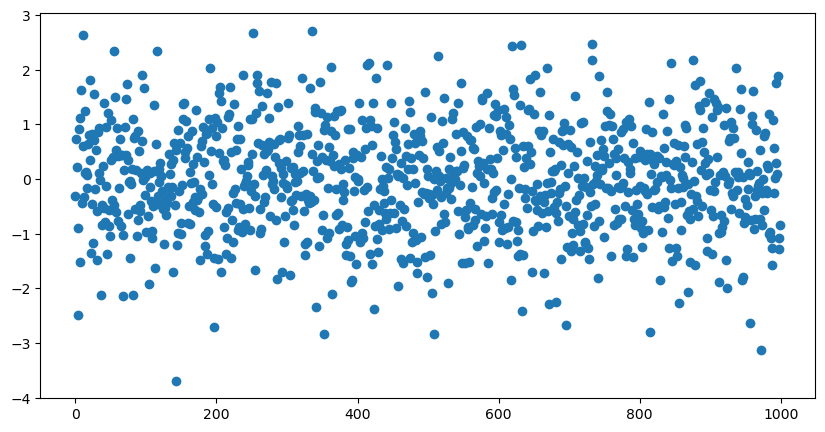

In [2]:
### Uncorrelated Gaussian

### Drift-Diffusion SDE
prec = 2

# Time discretization
Nt = 1000 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
np.random.seed(6)
# Noise level
sigma = 1

# Initialize the time series
time_series = []
mean_series = []
sigma_series = []

# Generate the drift-diffusion time series
for t in range(0, Nt):
    W =  np.random.normal() * sigma 
    
    time_series.append(W)
    mean_series.append(0)
    sigma_series.append(sigma)
    
plt.figure(figsize=(10, 5))
plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)



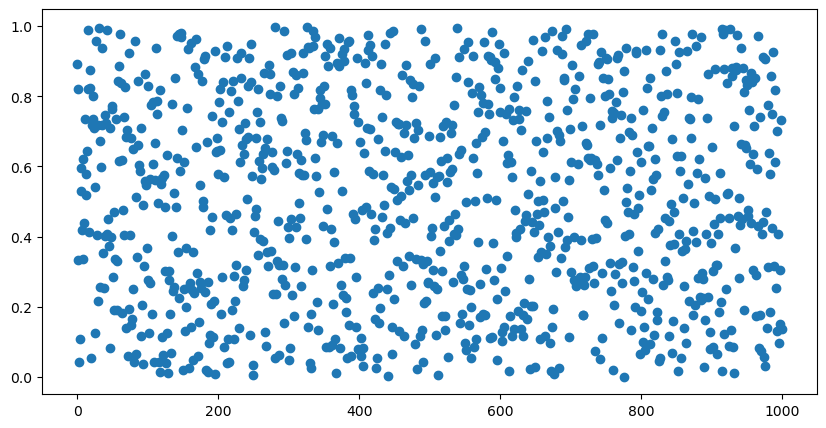

In [14]:
### Uncorrelated Uniform

### Drift-Diffusion SDE
prec = 2

# Time discretization
Nt = 1000 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
np.random.seed(6)
# Noise level
sigma = 1

# Initialize the time series
time_series = []
mean_series = []
sigma_series = []

# Generate the drift-diffusion time series
for t in range(0, Nt):
    W =  np.random.uniform() * sigma 
    
    time_series.append(W)
    mean_series.append(0)
    sigma_series.append(sigma)
    
plt.figure(figsize=(10, 5))
plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)



## Extracing logits

### Convert time series to strings

In [99]:
settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
time_series = np.array(time_series)
### Final range is from 0.15 to 0.85
rescale_factor = 0.7
up_shift = 0.15

rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
rescaled_true_sigma_arr = np.array(sigma_series)/(time_series.max()-time_series.min()) * rescale_factor 
rescaled_true_mean_arr *= 10
rescaled_true_sigma_arr *= 10
full_series = serialize_arr(rescaled_array, settings)


In [100]:
len(full_series)

3000

Cache common prompt: https://github.com/ggerganov/llama.cpp/pull/3228

define full series
For value in sequence: <br>    
    initialize multi_digit_pdf object <br>
    for digit in value: <br>
        initialize 10 synthetic sequences of the same length <br>
        generate synthetic sequence <br>

In [101]:
import torch
torch.cuda.empty_cache()
from models.llama import get_model_and_tokenizer, get_tokenizer

model, tokenizer = get_model_and_tokenizer('13b')
# model, tokenizer = get_model_and_tokenizer('70b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [102]:
batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )


### Compute Main Branch Logits

In [103]:
### Use cpu for initial pass if cuda out of memory
torch.cuda.empty_cache()
# model = model.cpu()

with torch.no_grad():
    # out = model(batch['input_ids'].cuda(), use_cache=True)
    out = model(batch['input_ids'].cpu(), use_cache=True)


logit_mat = out['logits'] 
kv_cache_main = out['past_key_values']

good_tokens_str = list("0123456789")
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
logit_mat_good = logit_mat[:,:,good_tokens].clone()

### Populate MultiResolution Dist with refined logits

In [109]:
T = 1
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)

PDF_list = []
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])

for i in tqdm(range(len(comma_locations))):
    PDF = MultiResolutionPDF()
    # slice out the number before ith comma
    if i == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[i-1]+1
    end_idx = comma_locations[i]
    num_slice = full_series[start_idx:end_idx]
    prob_slice = probs[0,start_idx:end_idx].cpu().numpy()
    ### Load hierarchical PDF 
    PDF.load_from_num_prob(num_slice, prob_slice)
    
    ### Refine hierarchical PDF
    seq = full_series[:end_idx]
    # cache and full_series are shifted from beginning, not end
    end_idx_neg = end_idx - len(full_series)
    ### kv cache contains seq[0:-1]
    kv_cache = trim_kv_cache(kv_cache_main, end_idx_neg-1)
    recursive_refiner(PDF, seq, curr = -prec, main = True, refine_depth = -1, mode = "neighbor", 
                    kv_cache = kv_cache, model = model, tokenizer = tokenizer, good_tokens=good_tokens)

    PDF_list += [PDF]
    
        
    

100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


In [110]:
### Pickle PDF_list

with open(f"MultiPDFList/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
    pickle.dump(PDF_list, f)


In [111]:
# ### Load pickled file to PDF_list
    
# ### model all, 300 steps, Brownian motion, rescale = 0.7
# with open("MultiPDFList/2023-12-18_23-42-05.pkl", 'rb') as f:
#     PDF_list = pickle.load(f)    
    
# ### model all, 300 steps, Brownian motion, rescale = 0.6
# with open("MultiPDFList/2023-12-18_03-39-02.pkl", 'rb') as f:
#     PDF_list = pickle.load(f)  
    
### model all, depth = -2, 1000 steps, Brownian motion, rescale = 0.6, up_dhift = 0.15
# with open("MultiPDFList/2023-12-19_03-27-47.pkl", 'rb') as f:
#     PDF_list = pickle.load(f)  

# ### model all, depth = -1, prec = 2, uncorrelated gaussian
# with open("MultiPDFList/2023-12-22_17-28-45.pkl", 'rb') as f:
#     PDF_list = pickle.load(f)  

## model neighbor, depth = -1, prec = 2, logistic map
with open("MultiPDFList/2023-12-22_21-31-21.pkl", 'rb') as f:
    PDF_list = pickle.load(f)  

### Calculate true discretized distribution: PDF_list_true
### Compute discretized BT and KL loss

In [112]:
PDF_true_list = copy.deepcopy(PDF_list)
discrete_BT_loss = []
discrete_KL_loss = []
for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def func(x):
        return np.exp(- (x - true_mean)**2 / (2 * true_sigma**2)) / true_sigma / np.sqrt(2 * np.pi)
    PDF_true.discretize(func)
    PDF_true.compute_stats()
    discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
    discrete_KL_loss += [PDF_true.KL_div(PDF)]

discrete_BT_loss = np.array(discrete_BT_loss)
discrete_KL_loss = np.array(discrete_KL_loss)


/tmp/ipykernel_102050/3718152424.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.exp(- (x - true_mean)**2 / (2 * true_sigma**2)) / true_sigma / np.sqrt(2 * np.pi)
/tmp/ipykernel_102050/3718152424.py:6: RuntimeWarning: invalid value encountered in divide
  return np.exp(- (x - true_mean)**2 / (2 * true_sigma**2)) / true_sigma / np.sqrt(2 * np.pi)


In [53]:
### tune temperature 
alpha = 1
for PDF in PDF_list:
    PDF.rescale_temperature(alpha)

In [113]:

### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])

log_scale = 0
plot1_log_scale = 0

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1
    fig, axs = plt.subplots(3, 1, figsize=(18, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(time_series, marker='o', color='black', markersize=3, lw = '0.1')
    axs[0].plot(comma_idx-1, time_series[comma_idx-1], color='r', marker='o')
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")      
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale)
    PDF_true_list[comma_idx].plot(ax = axs[2], log_scale=log_scale)
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx]
    true_sigma = rescaled_true_sigma_arr[comma_idx]
    x_values = np.linspace(0, 10, 300)
    gaussian = norm.pdf(x_values, true_mean, true_sigma)
    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].legend()
    if plot1_log_scale:
        axs[1].set_ylim(0.005,10)
    # return fig

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=999, min=1), Output()), _dom_classes=('w…

<function __main__.digiprob_plotter(comma_idx=1)>

### Mean, mode, and moments

In [124]:
### Use MultiResolutionPDF to define loss 

mean_arr = []
mode_arr = []
sigma_arr = []
moment_3_arr = []
moment_4_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    PDF_list[comma_idx].compute_stats()
    mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
    moment_3 = PDF_list[comma_idx].compute_moment(3)
    moment_4 = PDF_list[comma_idx].compute_moment(4)
    
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)
    moment_3_arr.append(moment_3)
    moment_4_arr.append(moment_4)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)
moment_3_arr = np.array(moment_3_arr)
moment_4_arr = np.array(moment_4_arr)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


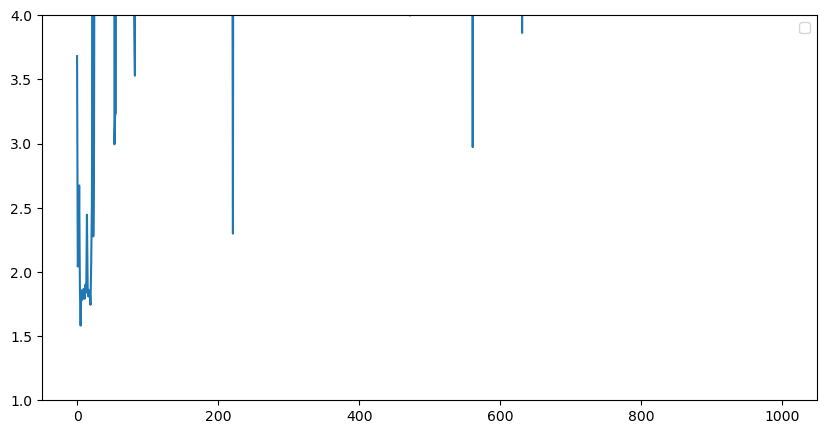

In [125]:
plt.figure(figsize=(10, 5))
# plt.plot(sigma_arr**2, label = "2rd moment")
# plt.plot(moment_3_arr, label = "3rd moment")
# plt.plot(moment_4_arr, label = "4th moment")
plt.plot(moment_4_arr/sigma_arr**4, label = "")
# plt.yscale('log')
plt.ylim(1, 4)
plt.legend()

### Sigma as an indicator of local lyapunov 

(-0.041187356308942887,
 0.8649344824878006,
 -0.05465812888489773,
 1.1478207065828523)

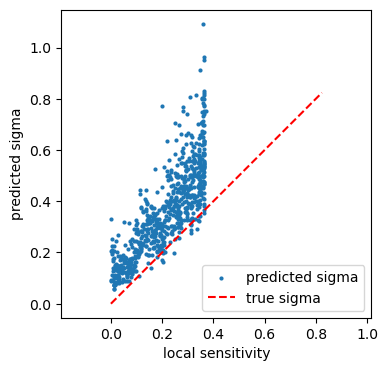

In [126]:
# plt.figure(figsize=(3, 6))
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_true_sigma_arr[300:],sigma_arr[300:], marker='.', lw=0, label = 'predicted sigma')

# max_val = np.max(rescaled_true_sigma_arr[500:])
# min_val = np.min(rescaled_true_sigma_arr[500:])

max_val = np.max(sigma_arr[500:])
# min_val = np.min(sigma_arr[500:])
min_val = 0
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label = 'true sigma')  # Add line of slope 1

# plt.xlabel(r'true sigma $\sim$ local lyapunov')
plt.xlabel(r'local sensitivity')

plt.ylabel('predicted sigma')
# plt.xlim(0, 0.5)
# plt.ylim(0, 0.5)
plt.legend()
plt.axis('equal')
# plt.loglog()


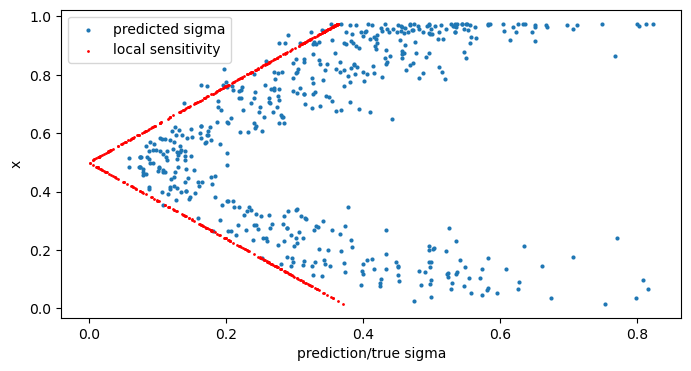

In [127]:
plt.figure(figsize=(8, 4))
plt.scatter(sigma_arr[501:], time_series[500:-1], marker = '.', lw=0, label = 'predicted sigma')
plt.scatter(rescaled_true_sigma_arr[501:], time_series[500:-1], color='red', s = 1, label = 'local sensitivity')
plt.ylabel('x')
plt.xlabel('prediction/true sigma')
plt.legend()

### Plot all in-context loss functions

In [95]:
good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
logit_mat_biased = logit_mat.clone()
logit_mat_biased[:,:,bad_tokens] = -np.inf
input_ids = batch['input_ids'][0][1:]

logprobs = torch.nn.functional.log_softmax(logit_mat_biased, dim=-1)[0][:-1]
# logprob of the full trajectory
logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
NLL = -logprobs

char_array = np.array(list(full_series))
comma_locations = np.where(char_array == ',')[0][:-1]+1

NLL_digit = -logprobs[comma_locations] \
            -logprobs[comma_locations+1] \
            -logprobs[comma_locations+2]

NameError: name 'tokenizer' is not defined

In [69]:
discrete_BT_loss.shape

(1000, 100)

/tmp/ipykernel_102050/2608467106.py:35: RuntimeWarning: divide by zero encountered in log
  BT_loss = error_mode / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
/tmp/ipykernel_102050/2608467106.py:38: RuntimeWarning: divide by zero encountered in divide
  KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2


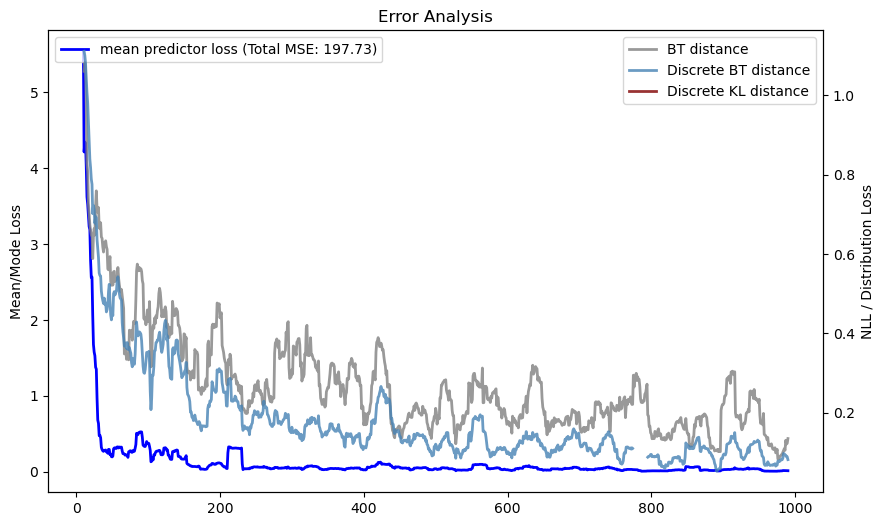

In [136]:
window_size = 20
xlog = 0
ylog = 0
scale_mean_mode_error = 0

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel

# Errors for mean_arr
if scale_mean_mode_error:   
    error_mean = np.abs(rescaled_true_mean_arr - mean_arr) / rescaled_true_mean_arr
else:
    error_mean = (rescaled_true_mean_arr - mean_arr) ** 2
averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')

# Errors for mode_arr

if scale_mean_mode_error:   
    error_mode = np.abs(rescaled_true_mean_arr - mode_arr) / rescaled_true_mean_arr
else:
    error_mode = (rescaled_true_mean_arr - mode_arr) ** 2
    
averaged_error_mode = np.convolve(error_mode, kernel, mode='valid')

# Errors sigma
error_sigma = np.abs(rescaled_true_sigma_arr - sigma_arr) #/ true_sigma_arr
averaged_error_sigma = np.convolve(error_sigma, kernel, mode='valid')

# Errors from NLL
# averaged_nll_digit = np.convolve(NLL_digit, kernel, mode='valid')

# Errors from Bhattacharya distance and KL divergence
BT_loss = error_mode / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')

KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')

averaged_discrete_BT_loss = np.convolve(discrete_BT_loss, kernel, mode='valid')
averaged_discrete_KL_loss = np.convolve(discrete_KL_loss, kernel, mode='valid')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the averaged errors
# ax1.plot(np.arange(window_size//2, len(error_mode) - window_size//2 + 1), averaged_error_mode, label=f"mode predictor loss (Total MSE: {np.sum(error_mode):.2f})", linewidth=2, c='lightblue')
ax1.plot(np.arange(window_size//2, len(error_mean) - window_size//2 + 1), averaged_error_mean, label=f"mean predictor loss (Total MSE: {np.sum(error_mean):.2f})", linewidth=2, c='blue')
# ax1.plot(np.arange(window_size//2, len(error_sigma) - window_size//2 + 1), averaged_error_sigma, label=f"sigma loss", linewidth=2, c='green')

ax1.set_ylabel("Mean/Mode Loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_nll_digit, label="NLL Digit Loss", linewidth=2, c='gray', alpha = 0.4)
# ax2.plot(np.arange(window_size//2, len(KL_loss) - window_size//2 + 1), averaged_KL_loss, label="KL divergence", linewidth=2, c='black', alpha = 0.8)
ax2.plot(np.arange(window_size//2, len(BT_loss) - window_size//2 + 1), averaged_BT_loss, label="BT distance", linewidth=2, c='gray', alpha = 0.8)
ax2.plot(np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1), averaged_discrete_BT_loss, label="Discrete BT distance", linewidth=2, c='steelblue', alpha = 0.8)
ax2.plot(np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1), averaged_discrete_KL_loss, label="Discrete KL distance", linewidth=2, c='maroon', alpha = 0.8)

# ax1.plot(X)

ax2.set_ylabel("NLL / Distribution Loss")
ax2.legend(loc='upper right')

if xlog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
if ylog:
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
# plt.xlim(0,150)
    
plt.xlabel("Time Steps Seen")
plt.title("Error Analysis")
plt.show()



### Discretized KL divergence